In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
""" Note that you need to alter tmin to -1, tmax to 5, and baseline to (None, 1) for this plot to correctl visualize -1 to 5 seconds """

' Note that you need to alter tmin to -1, tmax to 5, and baseline to (None, 1) for this plot to correctl visualize -1 to 5 seconds '

CONSTANTS

In [4]:
from helpers import extract_eeg, preprocess, prepare_data, run_model, evaluate_model, compute_empirical_chance
from pathlib import Path
import os
import matplotlib.pyplot as plt

In [5]:
MODEL = 'lda'                       # classifier ('svm', 'rf', 'lda', 'xgb')
PCA, N_COMPONENTS = True, 20        # PCA downsampling
TIME_DOWNSAMPLE_FACTOR = 4          # Time downsampling factor
N_FOLDS = 4                         # num. folds for K_folds

In [75]:
import numpy as np
import mne

channel = 'Cz'
window_size = 50  # Num samples in moving average window

def moving_average(signal, window_size):
    return np.convolve(signal, np.ones(window_size) / window_size, mode='valid')

def compute_grand_average_with_error(epochs, channel, window_size):
    data = epochs.get_data(picks=channel)  # Shape: (n_epochs, n_times)
    smoothed_signals = []

    for epoch_signal in data:  # Each epoch_signal is a 1D array (n_times,)
        smoothed_signal = moving_average(epoch_signal.flatten(), window_size)
        smoothed_signals.append(smoothed_signal)
    
    smoothed_signals = np.array(smoothed_signals)  # Shape: (n_epochs, n_times after smoothing)
    grand_averaged_signal = np.mean(smoothed_signals, axis=0)
    standard_error = np.std(smoothed_signals, axis=0) / np.sqrt(smoothed_signals.shape[0])  # SEM
    return grand_averaged_signal, standard_error

def compute_grand_average_without_error(epochs, channel, window_size):
    data = epochs.get_data(picks=channel)  # Shape: (n_epochs, n_times)
    smoothed_signals = []

    for epoch_signal in data:  # Each epoch_signal is a 1D array (n_times,)
        smoothed_signal = moving_average(epoch_signal.flatten(), window_size)
        smoothed_signals.append(smoothed_signal)
    
    smoothed_signals = np.array(smoothed_signals)  # Shape: (n_epochs, n_times after smoothing)
    grand_averaged_signal = np.mean(smoothed_signals, axis=0)
    standard_error = np.std(smoothed_signals, axis=0) / np.sqrt(smoothed_signals.shape[0])  # SEM
    return grand_averaged_signal

def plot_CNV(go_epochs, nogo_epochs): #go_extras, nogo_extras):
    # # (USED WHEN EXTRAS PARAMS ARE ADDED) extras are the individual subject average signals that will be plotted as background
    # jh_go, tr_go, rn_go = [compute_grand_average_without_error(i, channel, window_size) for i in go_extras]
    # jh_nogo, tr_nogo, rn_nogo = [compute_grand_average_without_error(i, channel, window_size) for i in nogo_extras]

    # Compute grand averages for each condition
    go_grand_avg, go_std_error = compute_grand_average_with_error(go_epochs, channel, window_size)
    nogo_grand_avg, nogo_std_error = compute_grand_average_with_error(nogo_epochs, channel, window_size)

    # Time axis (adjusted for your -1 to 5 seconds range)
    sampling_rate = go_epochs.info['sfreq']
    time_points = np.linspace(-1, 5, len(go_grand_avg))  # Match the length of averaged signals

    # Find the index of the least value in go_grand_avg
    min_idx = np.argmin(go_grand_avg)
    min_time = time_points[min_idx]
    min_value = go_grand_avg[min_idx]

    # Plot
    plt.figure(figsize=(10, 6))

    # Plot go condition
    plt.plot(time_points, go_grand_avg, label='Go', color='blue')
    plt.fill_between(time_points, go_grand_avg - go_std_error, go_grand_avg + go_std_error, 
                    color='blue', alpha=0.2)

    # Plot nogo condition
    plt.plot(time_points, nogo_grand_avg, label='NoGo', color='red')
    plt.fill_between(time_points, nogo_grand_avg - nogo_std_error, nogo_grand_avg + nogo_std_error, 
                    color='red', alpha=0.2)
    
    # Plot go extras
    # alph = 0.4
    # plt.plot(time_points, jh_go, color='blue', alpha=alph)
    # plt.plot(time_points, tr_go, color='blue', alpha=alph)
    # plt.plot(time_points, rn_go, color='blue', alpha=alph)
    # plt.plot(time_points, jh_nogo, color='red', alpha=alph)
    # plt.plot(time_points, tr_nogo, color='red', alpha=alph)
    # plt.plot(time_points, rn_nogo, color='red', alpha=alph)
    
    # Highlight the least value point
    plt.scatter(min_time, min_value, color='black', zorder=5, s=15, edgecolor='black')

    # Add a label next to the point
    plt.text(min_time + 0.1, min_value, f'Min Value at {min_time:.2f}s', 
             fontsize=7, color='black', verticalalignment='bottom', horizontalalignment='left')

    # Add vertical lines for S1 and S2
    plt.axvline(x=0, color='black', linestyle='--', label='S1 (0 s)')
    plt.axvline(x=4.3, color='black', linestyle='--', label='S2 (4.3 s)')

    # Labels and legend
    plt.title(f'Grand Averaged Signals with Std Error for {channel}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()


EXTRACT EEG

In [25]:
# Data Split A
train_pth_A = Path(r"data/train_A")                    # ses1 
train_pth_A_jh = Path(r"data/train_A_jh")              # ses1 
train_pth_A_rn = Path(r"data/train_A_rn")              # ses1 
train_pth_A_tr = Path(r"data/train_A_tr")              # ses1 

test_pth_A_s2 = Path(r"data/test_A_ses2")              # ses2
test_pth_A_s2_jh = Path(r"data/test_A_ses2_jh")        # ses2
test_pth_A_s2_rn = Path(r"data/test_A_ses2_rn")        # ses2
test_pth_A_s2_tr = Path(r"data/test_A_ses2_tr")        # ses2

test_pth_A_s3 = Path(r"data/test_A_ses3")              # ses3
test_pth_A_s3_jh = Path(r"data/test_A_ses3_jh")        # ses3
test_pth_A_s3_rn = Path(r"data/test_A_ses3_rn")        # ses3
test_pth_A_s3_tr = Path(r"data/test_A_ses3_tr")        # ses3

# Data Split B 
train_pth_B = Path(r"data/train_B")                # ses1 + ses2
train_pth_B_jh = Path(r"data/train_B_jh")          # ses1 + ses2
train_pth_B_rn = Path(r"data/train_B_rn")          # ses1 + ses2
train_pth_B_tr = Path(r"data/train_B_tr")          # ses1 + ses2

test_pth_B = Path(r"data/test_B")                  # ses3
test_pth_B_jh = Path(r"data/test_B_jh")            # ses3
test_pth_B_rn = Path(r"data/test_B_rn")               # ses3
test_pth_B_tr = Path(r"data/test_B_tr")               # ses3

# train data load (use .fif if exists else create new)
all_go_epochs_train_A, all_nogo_epochs_train_A = extract_eeg(folder_name=train_pth_A, fif_name=Path(r"loaded_data/train_A.fif"))
all_go_epochs_train_A_jh, all_nogo_epochs_train_A_jh = extract_eeg(folder_name=train_pth_A_jh, fif_name=Path(r"loaded_data/train_A_jh.fif"))
all_go_epochs_train_A_rn, all_nogo_epochs_train_A_rn = extract_eeg(folder_name=train_pth_A_rn, fif_name=Path(r"loaded_data/train_A_rn.fif"))
all_go_epochs_train_A_tr, all_nogo_epochs_train_A_tr = extract_eeg(folder_name=train_pth_A_tr, fif_name=Path(r"loaded_data/train_A_tr.fif"))

all_go_epochs_train_B, all_nogo_epochs_train_B = extract_eeg(folder_name=train_pth_B, fif_name=Path(r"loaded_data/train_B.fif"))
all_go_epochs_train_B_jh, all_nogo_epochs_train_B_jh = extract_eeg(folder_name=train_pth_B_jh, fif_name=Path(r"loaded_data/train_B_jh.fif"))
all_go_epochs_train_B_rn, all_nogo_epochs_train_B_rn = extract_eeg(folder_name=train_pth_B_rn, fif_name=Path(r"loaded_data/train_B_rn.fif"))
all_go_epochs_train_B_tr, all_nogo_epochs_train_B_tr = extract_eeg(folder_name=train_pth_B_tr, fif_name=Path(r"loaded_data/train_B_tr.fif"))

# test data
all_go_epochs_test_A_s2, all_nogo_epochs_test_A_s2 = extract_eeg(folder_name=test_pth_A_s2, fif_name=Path(r"loaded_data/test_A_s2.fif"))
all_go_epochs_test_A_s2_jh, all_nogo_epochs_test_A_s2_jh = extract_eeg(folder_name=test_pth_A_s2_jh, fif_name=Path(r"loaded_data/test_A_s2_jh.fif"))
all_go_epochs_test_A_s2_rn, all_nogo_epochs_test_A_s2_rn = extract_eeg(folder_name=test_pth_A_s2_rn, fif_name=Path(r"loaded_data/test_A_s2_rn.fif"))
all_go_epochs_test_A_s2_tr, all_nogo_epochs_test_A_s2_tr = extract_eeg(folder_name=test_pth_A_s2_tr, fif_name=Path(r"loaded_data/test_A_s2_tr.fif"))

all_go_epochs_test_A_s3, all_nogo_epochs_test_A_s3 = extract_eeg(folder_name=test_pth_A_s3, fif_name=Path(r"loaded_data/test_A_s3.fif"))
all_go_epochs_test_A_s3_jh, all_nogo_epochs_test_A_s3_jh = extract_eeg(folder_name=test_pth_A_s3_jh, fif_name=Path(r"loaded_data/test_A_s3_jh.fif"))
all_go_epochs_test_A_s3_rn, all_nogo_epochs_test_A_s3_rn = extract_eeg(folder_name=test_pth_A_s3_rn, fif_name=Path(r"loaded_data/test_A_s3_rn.fif"))
all_go_epochs_test_A_s3_tr, all_nogo_epochs_test_A_s3_tr = extract_eeg(folder_name=test_pth_A_s3_tr, fif_name=Path(r"loaded_data/test_A_s3_tr.fif"))

all_go_epochs_test_B, all_nogo_epochs_test_B = extract_eeg(folder_name=test_pth_B, fif_name=Path(r"loaded_data/test_B.fif"))
all_go_epochs_test_B_jh, all_nogo_epochs_test_B_jh = extract_eeg(folder_name=test_pth_B_jh, fif_name=Path(r"loaded_data/test_B_jh.fif"))
all_go_epochs_test_B_rn, all_nogo_epochs_test_B_rn = extract_eeg(folder_name=test_pth_B_rn, fif_name=Path(r"loaded_data/test_B_rn.fif"))
all_go_epochs_test_B_tr, all_nogo_epochs_test_B_tr = extract_eeg(folder_name=test_pth_B_tr, fif_name=Path(r"loaded_data/test_B_tr.fif"))

File loaded_data\train_A.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\train_A.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available


c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\train_A.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)


Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\train_A_jh.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\train_A_jh.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\train_A_rn.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\train_A_rn.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available


c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\train_A_jh.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\train_A_rn.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)


Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\train_A_tr.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\train_A_tr.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\train_B.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\train_B.fif ...


c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\train_A_tr.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\train_B.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)


    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
456 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\train_B_jh.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\train_B_jh.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available


c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\train_B_jh.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)


Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\train_B_rn.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\train_B_rn.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available


c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\train_B_rn.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)


Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\train_B_tr.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\train_B_tr.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata


c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\train_B_tr.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)


144 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\test_A_s2.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\test_A_s2.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available


c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\test_A_s2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)


Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\test_A_s2_jh.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\test_A_s2_jh.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\test_A_s2_rn.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\test_A_s2_rn.fif ...
    Found the data of interest:


c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\test_A_s2_jh.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\test_A_s2_rn.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)


        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\test_A_s2_tr.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\test_A_s2_tr.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\test_A_s3.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\test_A_s3.fif ...


c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\test_A_s2_tr.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\test_A_s3.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)


    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\test_A_s3_jh.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\test_A_s3_jh.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\test_A_s3_rn.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\test_A_s3_rn.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms


c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\test_A_s3_jh.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\test_A_s3_rn.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)


        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\test_A_s3_tr.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\test_A_s3_tr.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\test_B.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\test_B.fif ...


c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\test_A_s3_tr.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\test_B.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)


    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\test_B_jh.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\test_B_jh.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\test_B_rn.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\test_B_rn.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available


c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\test_B_jh.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\test_B_rn.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)


Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\test_B_tr.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\test_B_tr.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated


c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\test_B_tr.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)


PREPROCESS

In [27]:
all_go_epochs_train_A, all_nogo_epochs_train_A = preprocess(all_go_epochs_train_A, all_nogo_epochs_train_A)
all_go_epochs_train_A_jh, all_nogo_epochs_train_A_jh = preprocess(all_go_epochs_train_A_jh, all_nogo_epochs_train_A_jh)
all_go_epochs_train_A_rn, all_nogo_epochs_train_A_rn = preprocess(all_go_epochs_train_A_rn, all_nogo_epochs_train_A_rn)
all_go_epochs_train_A_tr, all_nogo_epochs_train_A_tr = preprocess(all_go_epochs_train_A_tr, all_nogo_epochs_train_A_tr)

all_go_epochs_train_B, all_nogo_epochs_train_B = preprocess(all_go_epochs_train_B, all_nogo_epochs_train_B)
all_go_epochs_train_B_jh, all_nogo_epochs_train_B_jh = preprocess(all_go_epochs_train_B_jh, all_nogo_epochs_train_B_jh)
all_go_epochs_train_B_rn, all_nogo_epochs_train_B_rn = preprocess(all_go_epochs_train_B_rn, all_nogo_epochs_train_B_rn)
all_go_epochs_train_B_tr, all_nogo_epochs_train_B_tr = preprocess(all_go_epochs_train_B_tr, all_nogo_epochs_train_B_tr)

all_go_epochs_test_A_s2, all_nogo_epochs_test_A_s2 = preprocess(all_go_epochs_test_A_s2, all_nogo_epochs_test_A_s2)
all_go_epochs_test_A_s2_jh, all_nogo_epochs_test_A_s2_jh = preprocess(all_go_epochs_test_A_s2_jh, all_nogo_epochs_test_A_s2_jh)
all_go_epochs_test_A_s2_rn, all_nogo_epochs_test_A_s2_rn = preprocess(all_go_epochs_test_A_s2_rn, all_nogo_epochs_test_A_s2_rn)
all_go_epochs_test_A_s2_tr, all_nogo_epochs_test_A_s2_tr = preprocess(all_go_epochs_test_A_s2_tr, all_nogo_epochs_test_A_s2_tr)

all_go_epochs_test_A_s3, all_nogo_epochs_test_A_s3 = preprocess(all_go_epochs_test_A_s3, all_nogo_epochs_test_A_s3)
all_go_epochs_test_A_s3_jh, all_nogo_epochs_test_A_s3_jh = preprocess(all_go_epochs_test_A_s3_jh, all_nogo_epochs_test_A_s3_jh)
all_go_epochs_test_A_s3_rn, all_nogo_epochs_test_A_s3_rn = preprocess(all_go_epochs_test_A_s3_rn, all_nogo_epochs_test_A_s3_rn)
all_go_epochs_test_A_s3_tr, all_nogo_epochs_test_A_s3_tr = preprocess(all_go_epochs_test_A_s3_tr, all_nogo_epochs_test_A_s3_tr)

all_go_epochs_test_B, all_nogo_epochs_test_B = preprocess(all_go_epochs_test_B, all_nogo_epochs_test_B)
all_go_epochs_test_B_jh, all_nogo_epochs_test_B_jh = preprocess(all_go_epochs_test_B_jh, all_nogo_epochs_test_B_jh)
all_go_epochs_test_B_rn, all_nogo_epochs_test_B_rn = preprocess(all_go_epochs_test_B_rn, all_nogo_epochs_test_B_rn)
all_go_epochs_test_B_tr, all_nogo_epochs_test_B_tr = preprocess(all_go_epochs_test_B_tr, all_nogo_epochs_test_B_tr)

Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    1.2s
[Pa

Setting up band-pass filter from 0.1 - 1 Hz


[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.7s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    1.4s
[

EEG channel type selected for re-referencing


[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.9s


Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper pass

c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s


Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s


Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s


Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.6s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (

[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.6s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s


Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated


[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s


SSP projectors applied...
Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    1.3s
[Pa

Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    3.5s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.0s
[

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated


[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    3.8s


SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.8s


Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.0s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (

c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.0s


Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    1.2s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.0s
[

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (

c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.1s


Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (

[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.1s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.1s
[Pa

Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    1.1s
[

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (

c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (

[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (

[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (

[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.0s
[Pa

Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    1.2s
[

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (

c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (

[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s


Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s


Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.6s


Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    1.2s
[Pa

Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    1.2s
[

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (

c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (

[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (

[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s


Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s
c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.5s


In [28]:
# JH S1
jh_s1_go = all_go_epochs_train_A_jh
jh_s1_nogo = all_nogo_epochs_train_A_jh

# JH S2
jh_s2_go = all_go_epochs_test_A_s2_jh
jh_s2_nogo = all_nogo_epochs_test_A_s2_jh

# JH S3
jh_s3_go = all_go_epochs_test_A_s3_jh
jh_s3_nogo = all_nogo_epochs_test_A_s3_jh

# JH AVG
jh_avg_go = mne.concatenate_epochs([all_go_epochs_train_A_jh, all_go_epochs_test_A_s2_jh, all_go_epochs_test_A_s3_jh])
jh_avg_nogo = mne.concatenate_epochs([all_nogo_epochs_train_A_jh, all_nogo_epochs_test_A_s2_jh, all_nogo_epochs_test_A_s3_jh])

# TR S1
tr_s1_go = all_go_epochs_train_A_tr
tr_s1_nogo = all_nogo_epochs_train_A_tr

# TR S2
tr_s2_go = all_go_epochs_test_A_s2_tr
tr_s2_nogo = all_nogo_epochs_test_A_s2_tr

# TR S3
tr_s3_go = all_go_epochs_test_A_s3_tr
tr_s3_nogo = all_nogo_epochs_test_A_s3_tr

# TR AVG
tr_avg_go = mne.concatenate_epochs([all_go_epochs_train_A_tr, all_go_epochs_test_A_s2_tr, all_go_epochs_test_A_s3_tr])
tr_avg_nogo = mne.concatenate_epochs([all_nogo_epochs_train_A_tr, all_nogo_epochs_test_A_s2_tr, all_nogo_epochs_test_A_s3_tr])

# RN S1
rn_s1_go = all_go_epochs_train_A_rn
rn_s1_nogo = all_nogo_epochs_train_A_rn

# RN S2
rn_s2_go = all_go_epochs_test_A_s2_rn
rn_s2_nogo = all_nogo_epochs_test_A_s2_rn

# RN S3
rn_s3_go = all_go_epochs_test_A_s3_rn
rn_s3_nogo = all_nogo_epochs_test_A_s3_rn

# RN AVG
rn_avg_go = mne.concatenate_epochs([all_go_epochs_train_A_rn, all_go_epochs_test_A_s2_rn, all_go_epochs_test_A_s3_rn])
rn_avg_nogo = mne.concatenate_epochs([all_nogo_epochs_train_A_rn, all_nogo_epochs_test_A_s2_rn, all_nogo_epochs_test_A_s3_rn])

# S1 AVG
s1_avg_go = all_go_epochs_train_A
s1_avg_nogo = all_nogo_epochs_train_A

# S2 AVG
s2_avg_go = all_go_epochs_test_A_s2
s2_avg_nogo = all_nogo_epochs_test_A_s2

# S3 AVG
s3_avg_go = all_go_epochs_test_A_s3
s3_avg_nogo = all_nogo_epochs_test_A_s3

# GRAND AVG
grand_avg_go = mne.concatenate_epochs([all_go_epochs_train_A, all_go_epochs_test_A_s2, all_go_epochs_test_A_s3])
grand_avg_nogo = mne.concatenate_epochs([all_nogo_epochs_train_A, all_nogo_epochs_test_A_s2, all_nogo_epochs_test_A_s3])


Not setting metadata
108 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
Not setting metadata
108 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
Not setting metadata
108 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
Not setting metadata
108 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
Not setting metadata
120 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
Not setting metadata
120 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
Not setting metadata
336 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
Not setting metadata
336 matching 

Not setting metadata
336 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
Not setting metadata
336 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)


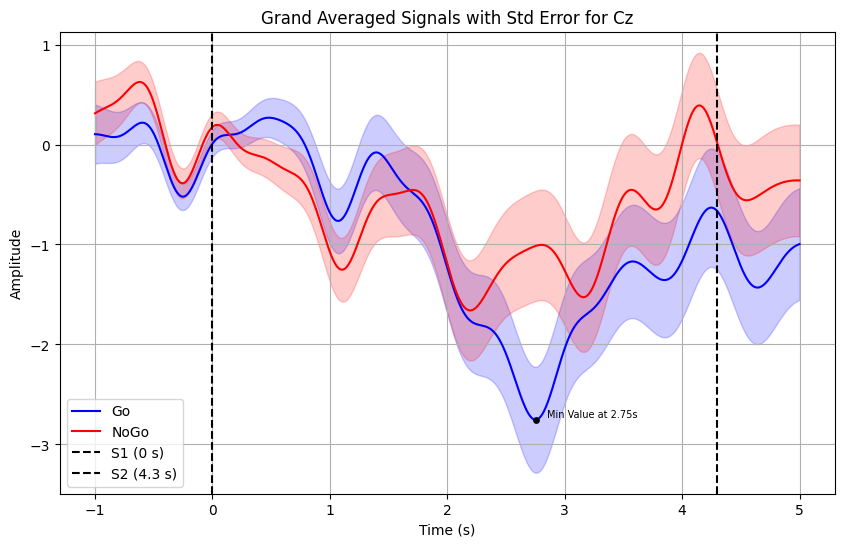

In [76]:
# Combine multiple go and nogo epoch objects
all_go_epochs = [all_go_epochs_train_A, all_go_epochs_test_A_s2, all_go_epochs_test_A_s3]
all_nogo_epochs = [all_nogo_epochs_train_A, all_nogo_epochs_test_A_s2, all_nogo_epochs_test_A_s3]

# Load go and nogo epochs (assuming you already have them as mne.Epochs objects)
go_epochs = mne.concatenate_epochs(all_go_epochs)
nogo_epochs = mne.concatenate_epochs(all_nogo_epochs)

go_extras = [jh_avg_go, tr_avg_go, rn_avg_go]
nogo_extras = [jh_avg_nogo, tr_avg_nogo, rn_avg_nogo]

plot_CNV(go_epochs, nogo_epochs)

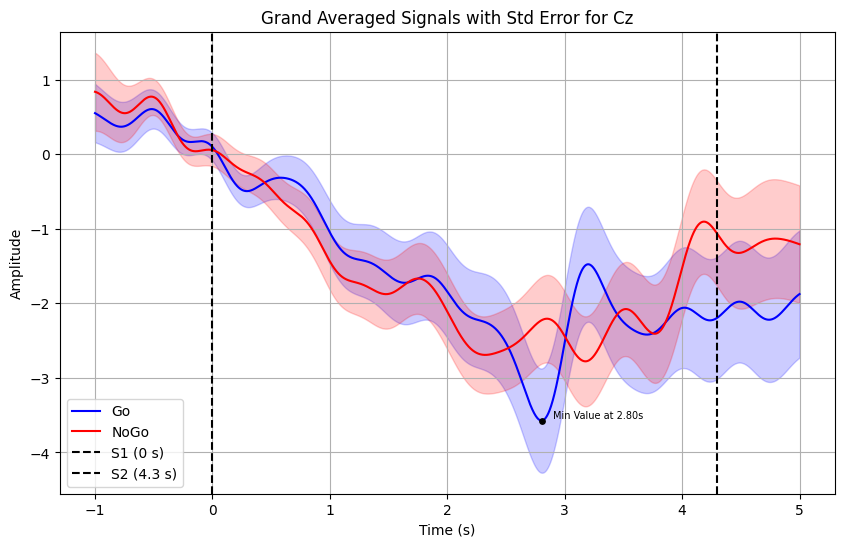

In [78]:
#jh
plot_CNV(go_extras[0], nogo_extras[0])

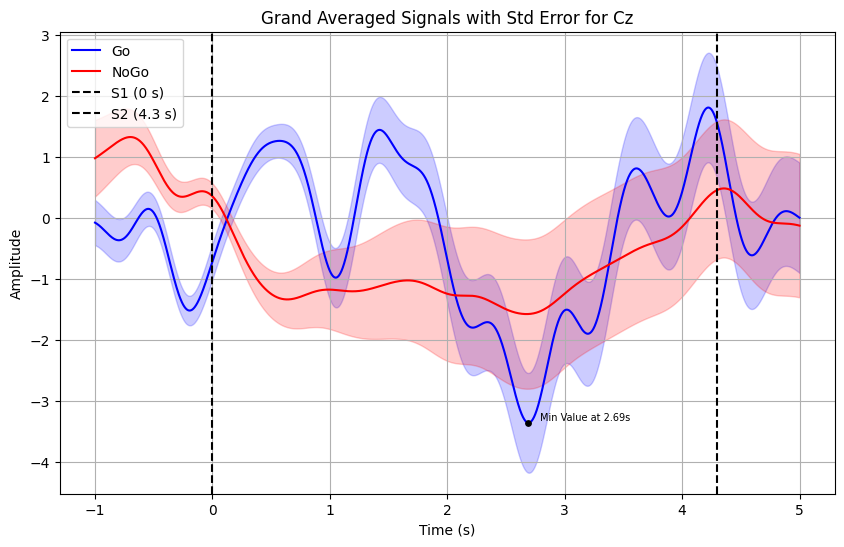

In [79]:
#tr
plot_CNV(go_extras[1], nogo_extras[2])

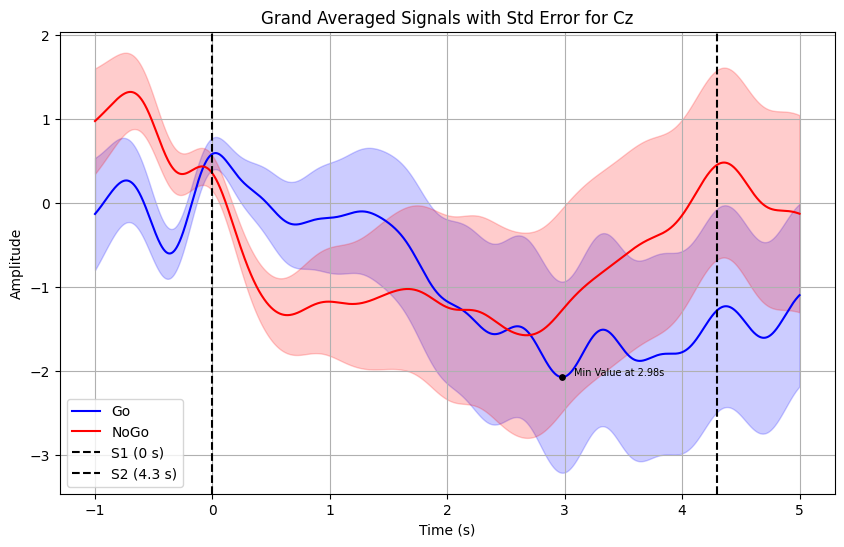

In [80]:
#rn
plot_CNV(go_extras[2], nogo_extras[2])

In [30]:
def window_average(epochs, window_size):

    # get raw data (shape: n_epochs, n_channels, n_times)
    data = epochs.get_data()
    n_epochs, n_channels, n_times = data.shape

    crop_start = 0 # to start at 2.3 s (orig at 1-4.3s, so 1.3s * 512 ~ 666)
    smoothed_data = np.zeros((n_epochs, n_channels, n_times - crop_start - window_size + 1))
    
    # Apply moving average per epoch, channel
    for i_epoch in range(n_epochs):
        for i_channel in range(n_channels):
            signal = data[i_epoch, i_channel, crop_start:n_times] # extract 2.3 to 4.3 period
            smoothed_data[i_epoch, i_channel] = moving_average(signal, window_size)
    
    # make new epoch object
    info = epochs.info
    times = epochs.times[:smoothed_data.shape[2]]  # Adjust time array for new length
    updated_epochs = mne.EpochsArray(smoothed_data, info, tmin=times[0])

    return updated_epochs

In [42]:
import mne
from mne.viz import plot_topomap

def plot_cnv_topoplots(go_epochs, nogo_epochs):
    # Compute grand averages for each condition
    go_epochs_avgd = window_average(go_epochs, window_size)
    nogo_epochs_avgd = window_average(nogo_epochs, window_size)

    # Define time points
    time_points = [0, 2.3, 2.75, 4.3]
    time_indices = [np.argmin(np.abs(go_epochs_avgd.times - t)) for t in time_points]

    # create figure
    fig, axes = plt.subplots(2, 4, figsize=(16, 6), constrained_layout=True)
    fig.suptitle("Go and No-Go at Different Time Points", fontsize=16)
    for i, t_idx in enumerate(time_indices):

        # Get data for topomap plotting
        go_data = go_epochs_avgd.get_data()[:, 0:32, t_idx].mean(axis=0)  # Average across epochs
        nogo_data = nogo_epochs_avgd.get_data()[:, 0:32, t_idx].mean(axis=0)

        im, _ = plot_topomap(
            go_data,  # Data at the specific time index
            go_epochs_avgd.info,
            axes=axes[0, i],
            show=False
        )
        axes[0, i].set_title(f"{time_points[i]}s (Go)", fontsize=10)

        im, _ = plot_topomap(
            nogo_data,  # Data at the specific time index
            nogo_epochs_avgd.info,
            axes=axes[1, i],
            show=False
        )
        axes[1, i].set_title(f"{time_points[i]}s (No-Go)", fontsize=10)

    plt.show()

C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
336 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
336 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\2501368905.py:19: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  go_data = go_epochs_avgd.get_data()[:, 0:32, t_idx].mean(axis=0)  # Average across epochs
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\2501368905.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  nogo_data = nogo_epochs_avgd.get_data()[:, 0:32, t_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\2501368905.py:19: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  go_data = go_epochs_avgd.get_data()[:, 0:32, t_idx].mean(axis=0)  # Average across epochs
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\2501368905.py:20: FutureWarning: The current default of copy=False will change t

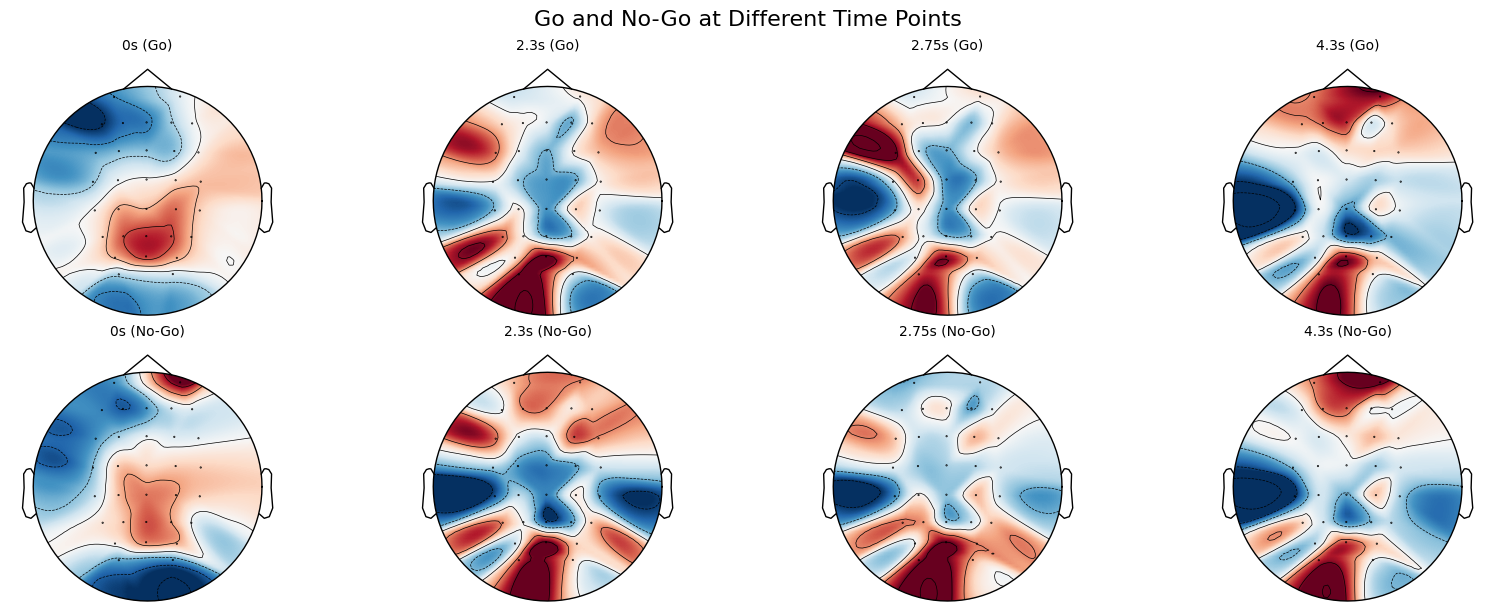

In [43]:
plot_cnv_topoplots(go_epochs, nogo_epochs)

In [122]:
import matplotlib.pyplot as plt
from mne.viz import plot_topomap

def plot_patient_session_topoplots(patients_sessions, time_mark, output_file):
    """
    Plot a 4x4 grid of topoplots (rows: patients, columns: sessions).

    Parameters:
    - patients_sessions: dict, keys are patient IDs, values are lists of session Epochs objects
    - time_mark: float, time in seconds for topoplot
    - output_file: str, path to save the high-quality figure

    Returns:
    - None
    """
    num_patients = len(patients_sessions)
    num_sessions = len(next(iter(patients_sessions.values())))

    # Define fixed colorbar range
    vmin, vmax = -4.5, 4.5

    # Create the figure
    fig, axes = plt.subplots(
        num_patients, num_sessions,
        figsize=(20, 15),
        constrained_layout=False,  # Disable constrained layout to use gridspec_kw
        gridspec_kw={"hspace": 0.4, "wspace": -0.7}  # Add spacing between rows (hspace) and columns (wspace)
    )
    fig.suptitle(f"Topoplots at {time_mark}s for All Subjects and Sessions", fontsize=16)

    plt.subplots_adjust(
        top=0.95,    # Reduce top margin
        bottom=0.05,  # Reduce bottom margin
        left=0.05,   # Reduce left margin
        right=0.99   # Reduce right margin
    )

    im_list = []

    # Iterate through patients and sessions
    for row, (patient_id, sessions) in enumerate(patients_sessions.items()):
        for col, epochs in enumerate(sessions):
            # Compute grand averages for each condition
            epochs_avgd = window_average(epochs, window_size)

            # Get the time index closest to the time mark
            time_idx = np.argmin(np.abs(epochs_avgd.times - time_mark))

            # Average across epochs and get the data for the time index
            data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)

            # Plot the topomap
            ax = axes[row, col] if num_patients > 1 else axes[col]
            im, _ = plot_topomap(
                data, epochs.info,
                axes=ax, show=False#, cmap="RdBu_r"
            )
            im.set_clim(vmin, vmax)  # Fix color limits
            im_list.append(im)

            # Customize subplot titles
            if row == num_patients - 1 and col == num_sessions - 1:
                title = "Grand Average"
            elif row == num_patients - 1:
                title = f"Avg. of Session {col+1}"
            elif col == num_sessions - 1:
                title = f"Avg. of Subject {row+1}"
            else:
                title = f"Subject {row+1}, Session {col+1}"
            
            # Set title for the subplot
            ax.set_title(title, fontsize=10)

    # Add a colorbar
    cbar = fig.colorbar(im_list[0], ax=axes, orientation="horizontal", shrink=0.5)
    cbar.set_label('Amplitude (µV)', fontsize=12)

    # Save the figure
    fig.savefig(output_file, dpi=300)  # Save at 300 DPI for high-quality
    plt.show()


Not setting metadata
36 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\1677633348.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


36 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
36 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\1677633348.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\1677633348.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
108 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
36 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\1677633348.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\1677633348.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


36 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
36 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\1677633348.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\1677633348.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
108 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
48 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\1677633348.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\1677633348.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
36 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
36 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\1677633348.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\1677633348.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
120 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\1677633348.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
120 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\1677633348.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
108 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\1677633348.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
108 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\1677633348.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
336 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\1677633348.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)


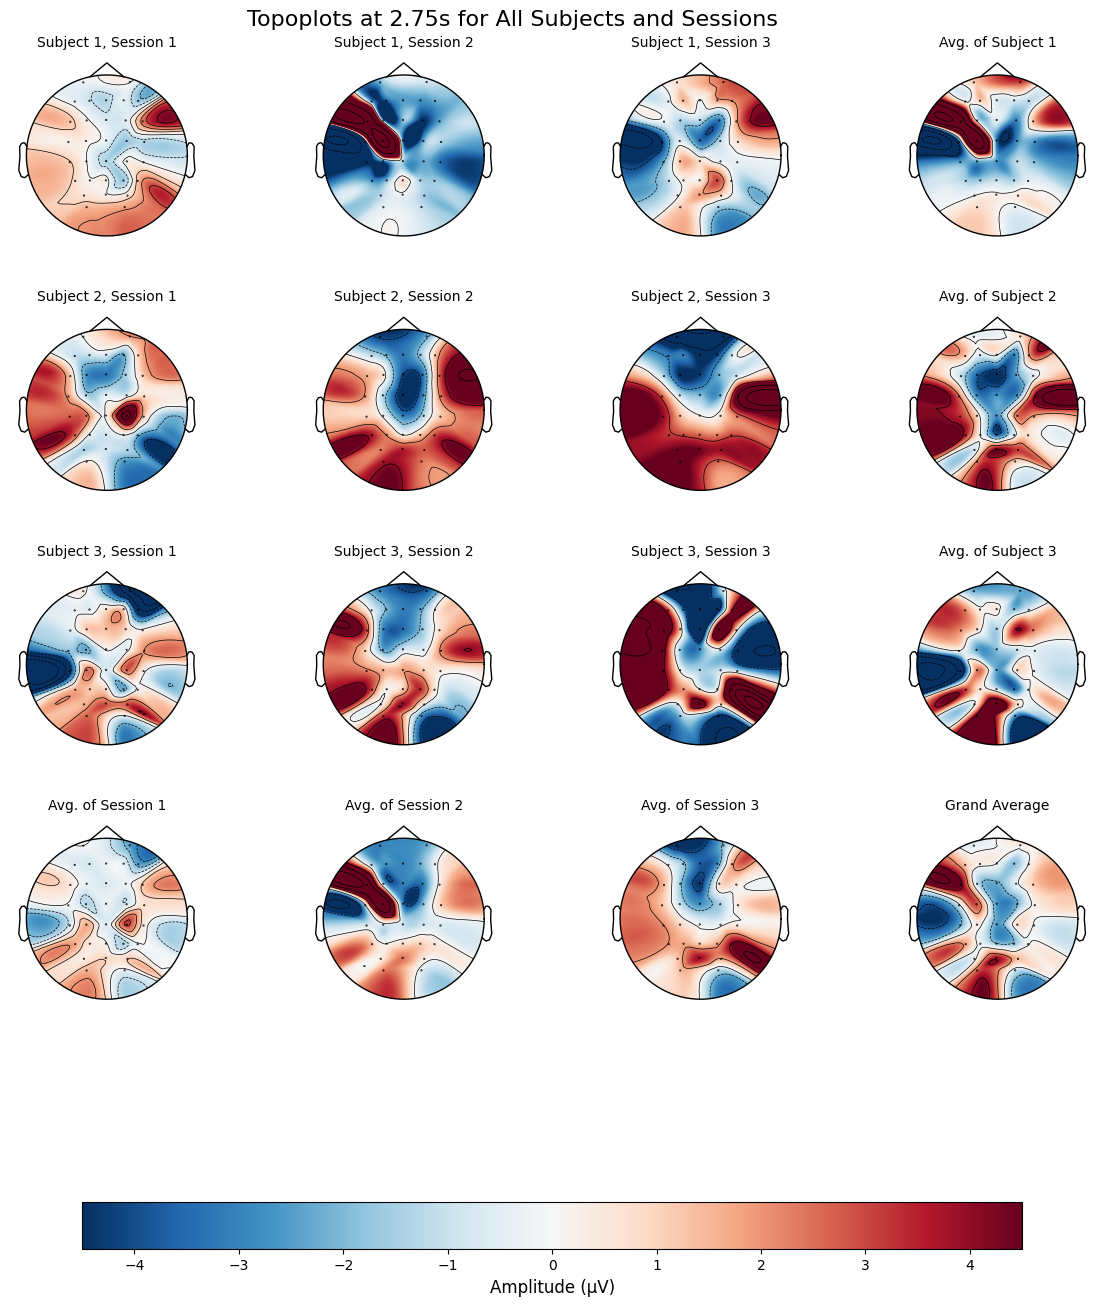

In [123]:
go_sessions = {
    1: [jh_s1_go, jh_s2_go, jh_s3_go, jh_avg_go],
    2: [tr_s1_go, tr_s2_go, tr_s3_go, tr_avg_go],
    3: [rn_s1_go, rn_s2_go, rn_s3_go, rn_avg_go],
    4: [s1_avg_go, s2_avg_go, s3_avg_go, grand_avg_go],
}

output_file = "topoplots_grid_go.png"  # Path to save the figure
time_mark = 2.75  # Time mark for the topoplots
plot_patient_session_topoplots(go_sessions, time_mark, output_file)

Not setting metadata
36 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
36 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\694131606.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\694131606.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:

Not setting metadata
36 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\694131606.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
108 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
36 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\694131606.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\694131606.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


36 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
36 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\694131606.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\694131606.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
108 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
48 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\694131606.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\694131606.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
36 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Not setting metadata
36 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\694131606.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\694131606.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
120 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\694131606.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
120 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\694131606.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
108 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\694131606.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
108 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\694131606.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\3131511456.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
336 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_36492\694131606.py:50: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_avgd.get_data()[:, 0:32, time_idx].mean(axis=0)


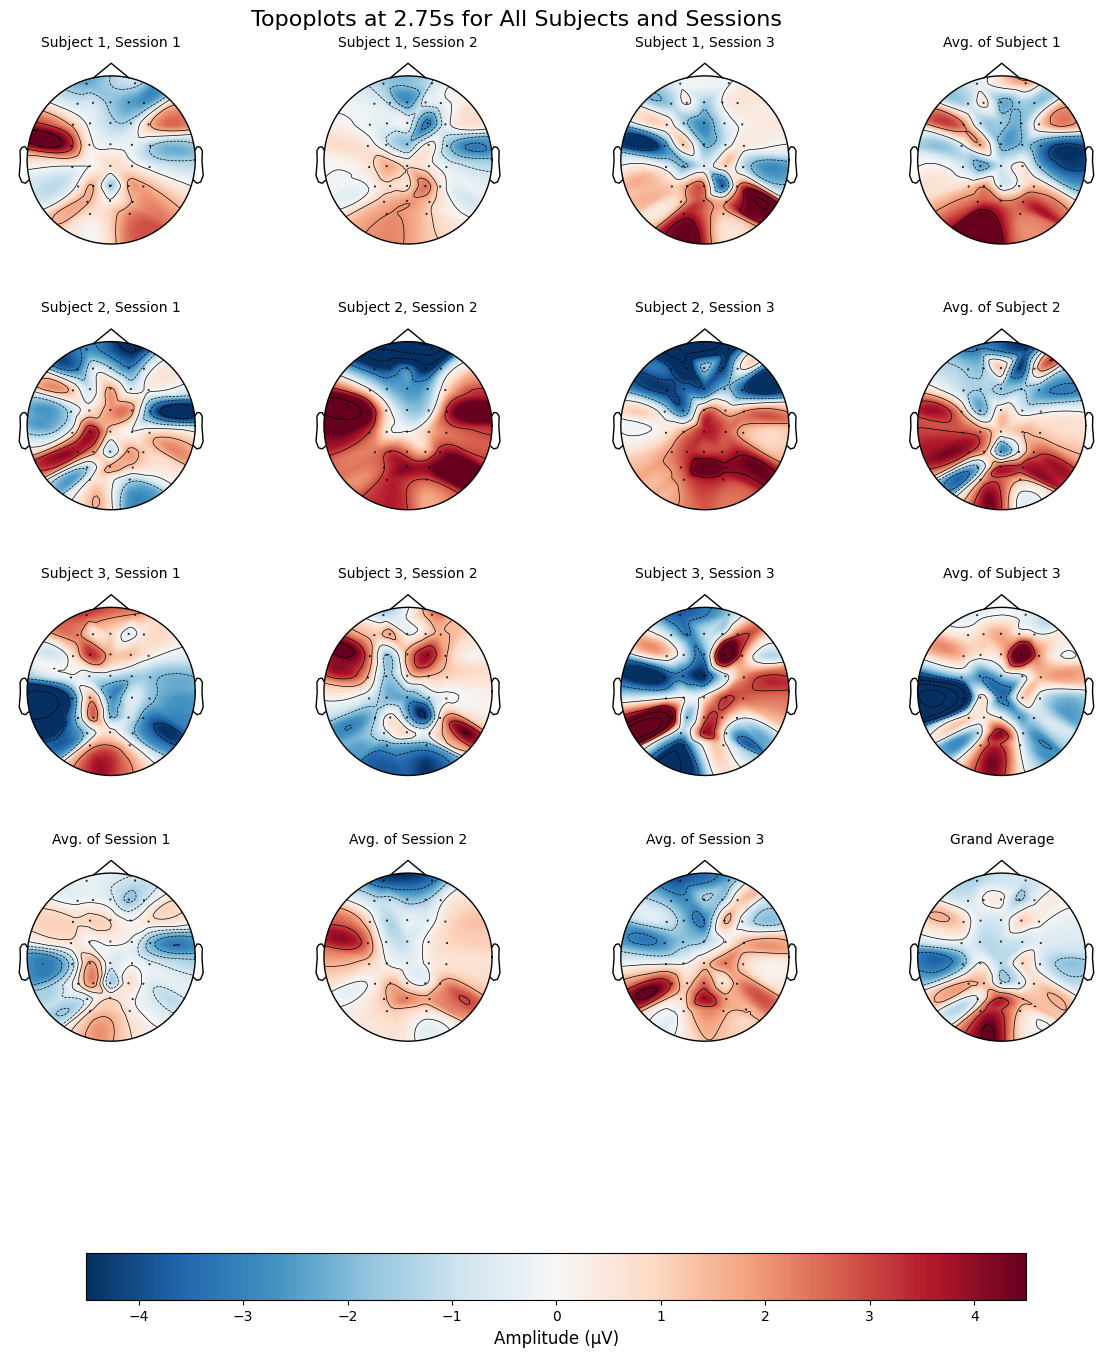

In [119]:
nogo_sessions = {
    1: [jh_s1_nogo, jh_s2_nogo, jh_s3_nogo, jh_avg_nogo],
    2: [tr_s1_nogo, tr_s2_nogo, tr_s3_nogo, tr_avg_nogo],
    3: [rn_s1_nogo, rn_s2_nogo, rn_s3_nogo, rn_avg_nogo],
    4: [s1_avg_nogo, s2_avg_nogo, s3_avg_nogo, grand_avg_nogo],
}

output_file = "topoplots_grid_nogo.png"  # Path to save the figure
time_mark = 2.75  # Time mark for the topoplots
plot_patient_session_topoplots(nogo_sessions, time_mark, output_file)